In [27]:
# Installing required package
!pip install yfinance --quiet

# Importing essential libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Displaying all columns while printing DataFrames
pd.set_option('display.max_columns', None)

In [28]:
# Selecting 10 liquid stocks from different sectors (NSE)
tickers = [
    'INFY.NS', 'TCS.NS', 'RELIANCE.NS', 'HDFCBANK.NS',
    'ITC.NS', 'LT.NS', 'HINDUNILVR.NS', 'SBIN.NS',
    'BHARTIARTL.NS', 'MARUTI.NS'
]

# Print tickers for confirmation
print("Selected tickers:", tickers)

Selected tickers: ['INFY.NS', 'TCS.NS', 'RELIANCE.NS', 'HDFCBANK.NS', 'ITC.NS', 'LT.NS', 'HINDUNILVR.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'MARUTI.NS']


In [29]:
# Downloading 10 years of historical daily data correctly for adjusted close prices
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', auto_adjust=True)

# 'auto_adjust=True' means downloaded data is already adjusted for splits/dividends, so we can directly use the 'Close' column and the result will already be a DataFrame of Close prices

# Displaying the first few rows
data.head()

[*********************100%***********************]  10 of 10 completed


Price              Close                                                    \
Ticker     BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS     INFY.NS      ITC.NS   
Date                                                                         
2015-01-01    308.073517  217.235336    638.149231  367.770752  173.042191   
2015-01-02    309.898712  220.258682    636.045776  374.998047  173.584229   
2015-01-05    303.022461  218.399048    639.705872  371.775665  174.267624   
2015-01-06    300.645508  214.999191    651.821655  364.008179  169.790131   
2015-01-07    301.367096  215.626709    674.707458  365.749847  166.632370   

Price                                                                     \
Ticker           LT.NS    MARUTI.NS RELIANCE.NS     SBIN.NS       TCS.NS   
Date                                                                       
2015-01-01  848.333313  3032.034668  189.999817  279.880554  1006.856323   
2015-01-02  866.226257  3049.142822  189.496948  280.994751  1020.265198   
2015-01-05  878.277283  3129.192871  187.421265  278.766388  1004.760193   
2015-01-06  848.982544  3081.498535  178.915237  267.312622   967.718323   
2015-01-07  846.950378  3120.071045  182.809799  267.535492   956.286987   

Price               High                                                    \
Ticker     BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS     INFY.NS      ITC.NS   
Date                                                                         
2015-01-01    309.771365  217.771559    641.052023  369.186397  173.866990   
2015-01-02    311.554104  221.171388    644.501696  376.087743  174.456148   
2015-01-05    310.917450  221.456603    641.052120  378.127457  175.233815   
2015-01-06    302.300899  218.262111    656.196872  369.745294  174.102628   
2015-01-07    303.913883  217.075624    678.830219  367.836059  171.557587   

Price                                                                     \
Ticker           LT.NS    MARUTI.NS RELIANCE.NS     SBIN.NS       TCS.NS   
Date                                                                       
2015-01-01  850.562845  3049.505795  190.877171  280.771894  1015.340548   
2015-01-02  868.681616  3070.380363  191.743828  283.713325  1024.813861   
2015-01-05  886.743966  3148.751505  190.641790  282.376302  1028.353874   
2015-01-06  871.927286  3121.205644  186.811392  277.295632  1000.350040   
2015-01-07  852.312645  3139.311930  183.772746  269.674701   980.592646   

Price                Low                                                    \
Ticker     BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS     INFY.NS      ITC.NS   
Date                                                                         
2015-01-01    298.523166  215.638102    634.531281  364.511034  172.500185   
2015-01-02    307.309497  216.858862    633.269213  367.323746  173.089342   
2015-01-05    301.876438  217.931275    635.330653  368.348299  173.230742   
2015-01-06    295.764190  213.926760    635.582918  360.264163  169.200983   
2015-01-07    297.546972  213.630165    655.439698  363.225884  166.373147   

Price                                                                     \
Ticker           LT.NS    MARUTI.NS RELIANCE.NS     SBIN.NS       TCS.NS   
Date                                                                       
2015-01-01  842.152646  3013.429052  189.090366  276.939145  1005.056616   
2015-01-02  847.514910  3040.883656  189.229471  280.192551  1008.854043   
2015-01-05  872.265855  3064.073205  187.046782  278.187023   998.589793   
2015-01-06  844.438730  3069.926749  178.037884  266.243031   965.107747   
2015-01-07  838.511912  3069.518269  179.107815  263.078795   952.232745   

Price               Open                                                    \
Ticker     BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS     INFY.NS      ITC.NS   
Date                                                                         
2015-01-01    300.857697  216.995754    638.864389  366.755569  

In [30]:
# Checking missing values
print("Missing values in each stock:")
print(data.isna().sum())

# Dropping rows with missing values
data = data.dropna()

# Confirming dataset shape after cleaning
print("\nCleaned data shape:", data.shape)

Missing values in each stock:
Price   Ticker       
Close   BHARTIARTL.NS    0
        HDFCBANK.NS      0
        HINDUNILVR.NS    0
        INFY.NS          0
        ITC.NS           0
        LT.NS            0
        MARUTI.NS        0
        RELIANCE.NS      0
        SBIN.NS          0
        TCS.NS           0
High    BHARTIARTL.NS    0
        HDFCBANK.NS      0
        HINDUNILVR.NS    0
        INFY.NS          0
        ITC.NS           0
        LT.NS            0
        MARUTI.NS        0
        RELIANCE.NS      0
        SBIN.NS          0
        TCS.NS           0
Low     BHARTIARTL.NS    0
        HDFCBANK.NS      0
        HINDUNILVR.NS    0
        INFY.NS          0
        ITC.NS           0
        LT.NS            0
        MARUTI.NS        0
        RELIANCE.NS      0
        SBIN.NS          0
        TCS.NS           0
Open    BHARTIARTL.NS    0
        HDFCBANK.NS      0
        HINDUNILVR.NS    0
        INFY.NS          0
        ITC.NS           0
   

In [31]:
# Computing log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Displaying first few rows of log returns
log_returns.head()

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Price              Close                                                \
Ticker     BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS   INFY.NS    ITC.NS   
Date                                                                     
2015-01-02      0.005907    0.013821     -0.003302  0.019461  0.003128   
2015-01-05     -0.022439   -0.008479      0.005738 -0.008630  0.003929   
2015-01-06     -0.007875   -0.015690      0.018762 -0.021114 -0.026029   
2015-01-07      0.002397    0.002914      0.034508  0.004773 -0.018773   
2015-01-08      0.017176    0.020788      0.018717  0.005029  0.024724   

Price                                                                   High  \
Ticker         LT.NS MARUTI.NS RELIANCE.NS   SBIN.NS    TCS.NS BHARTIARTL.NS   
Date                                                                           
2015-01-02  0.020873  0.005627   -0.002650  0.003973  0.013230      0.005739   
2015-01-05  0.013816  0.025915   -0.011014 -0.007962 -0.015314     -0.002046   
2015-01-06 -0.033924 -0.015359   -0.046447 -0.041955 -0.037563     -0.028105   
2015-01-07 -0.002397  0.012440    0.021534  0.000833 -0.011883      0.005322   
2015-01-08  0.006344  0.010921   -0.014443  0.015538  0.010738      0.013732   

Price                                                                         \
Ticker     HDFCBANK.NS HINDUNILVR.NS   INFY.NS    ITC.NS     LT.NS MARUTI.NS   
Date                                                                           
2015-01-02    0.015491      0.005367  0.018521  0.003383  0.021078  0.006822   
2015-01-05    0.001289     -0.005367  0.005409  0.004448  0.020580  0.025205   
2015-01-06   -0.014530      0.023350 -0.022417 -0.006476 -0.016850 -0.008787   
2015-01-07   -0.005451      0.033910 -0.005177 -0.014726 -0.022753  0.005784   
2015-01-08    0.018331      0.022308  0.011204 -0.001787  0.008901  0.014523   

Price                                                Low              \
Ticker     RELIANCE.NS   SBIN.NS    TCS.NS BHARTIARTL.NS HDFCBANK.NS   
Date                                                                   
2015-01-02    0.004530  0.010422  0.009287      0.029008    0.005645   
2015-01-05   -0.005764 -0.004724  0.003448     -0.017838    0.004933   
2015-01-06   -0.020297 -0.018156 -0.027609     -0.020455   -0.018546   
2015-01-07   -0.016400 -0.027868 -0.019948      0.006010   -0.001387   
2015-01-08    0.004763  0.012971 -0.012236      0.007532    0.012683   

Price                                                                 \
Ticker     HINDUNILVR.NS       INFY.NS    ITC.NS     LT.NS MARUTI.NS   
Date                                                                   
2015-01-02     -0.001991  7.686781e-03  0.003410  0.006347  0.009069   
2015-01-05      0.003250  2.785352e-03  0.000817  0.028786  0.007597   
2015-01-06      0.000397 -2.219141e-02 -0.023537 -0.032422  0.001909   
2015-01-07      0.030764  8.187363e-03 -0.016854 -0.007043 -0.000133   
2015-01-08      0.030531 -1.565371e-07  0.006917  0.012443  0.018152   

Price                                               Open              \
Ticker     RELIANCE.NS   SBIN.NS    TCS.NS BHARTIARTL.NS HDFCBANK.NS   
Date                                                                   
2015-01-02    0.000735  0.011679  0.003771      0.026178   -0.000631   
2015-01-05   -0.011602 -0.007183 -0.010226      0.006712    0.020413   
2015-01-06   -0.049362 -0.043884 -0.034104     -0.028105   -0.016633   
2015-01-07    0.005992 -0.011956 -0.013430     -0.011722   -0.015103   
2015-01-08    0.003756  0.024102  0.005427      0.012985    0.015365   

Price                                                                         \
Ticker     HINDUNILVR.NS   INFY.NS    ITC.NS     LT.NS MARUTI.NS RELIANCE.NS   
Date                                                                           
2015-01-02     -0.003034  0.001548 -0.000952  0.005141  0.011901    0.002029   
2015-01-05      0.003626  0.019037  0.003941  0.028786  0.006526   -0.0034

In [32]:
# Defining periods
in_sample = log_returns.loc['2015-01-01':'2020-12-31']
out_sample = log_returns.loc['2021-01-01':'2022-12-31']

# Printing shapes to confirm
print("In-sample data shape:", in_sample.shape)
print("Out-of-sample data shape:", out_sample.shape)

# Checking the time ranges
print("\nIn-sample range:", in_sample.index.min(), "to", in_sample.index.max())
print("Out-of-sample range:", out_sample.index.min(), "to", out_sample.index.max())

In-sample data shape: (1479, 50)
Out-of-sample data shape: (496, 50)

In-sample range: 2015-01-02 00:00:00 to 2020-12-31 00:00:00
Out-of-sample range: 2021-01-01 00:00:00 to 2022-12-30 00:00:00


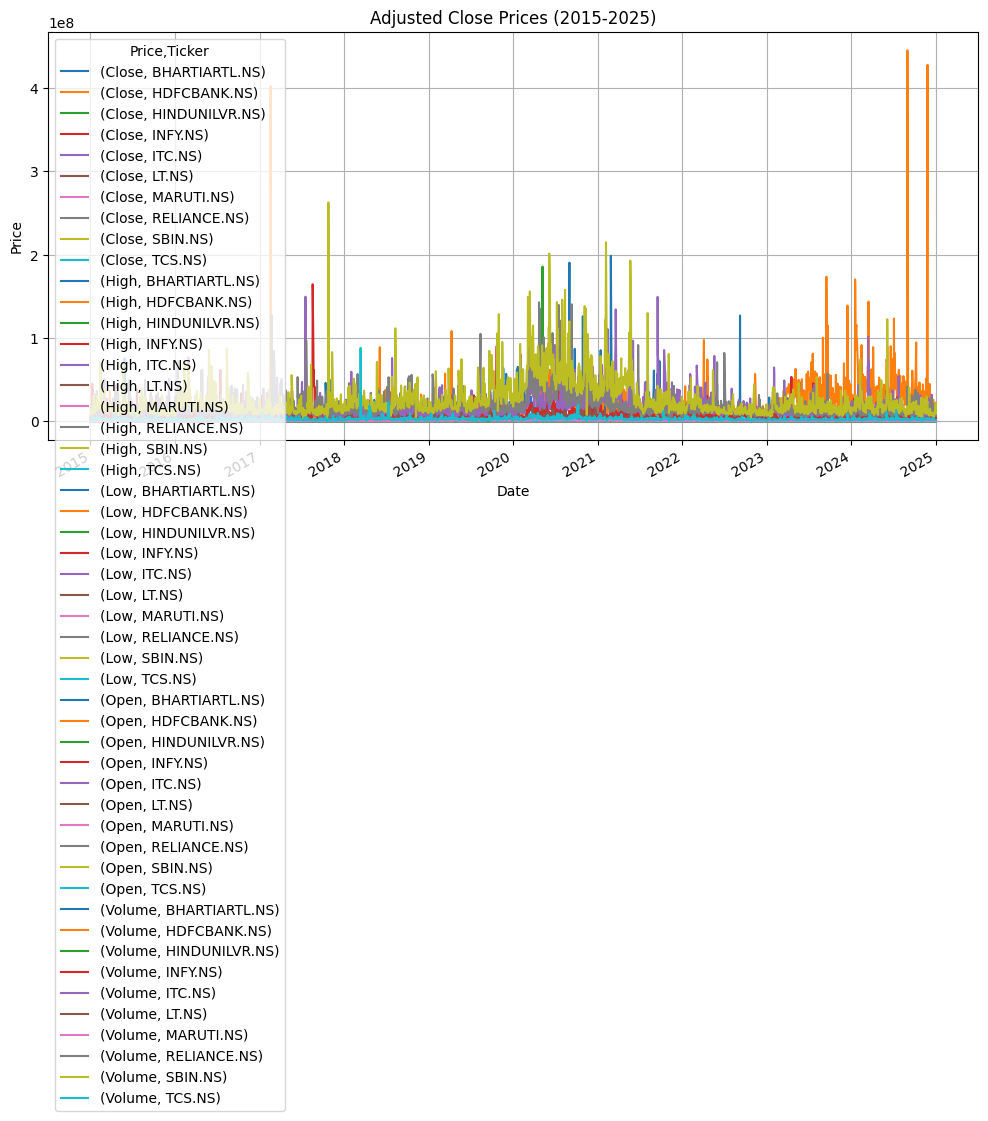

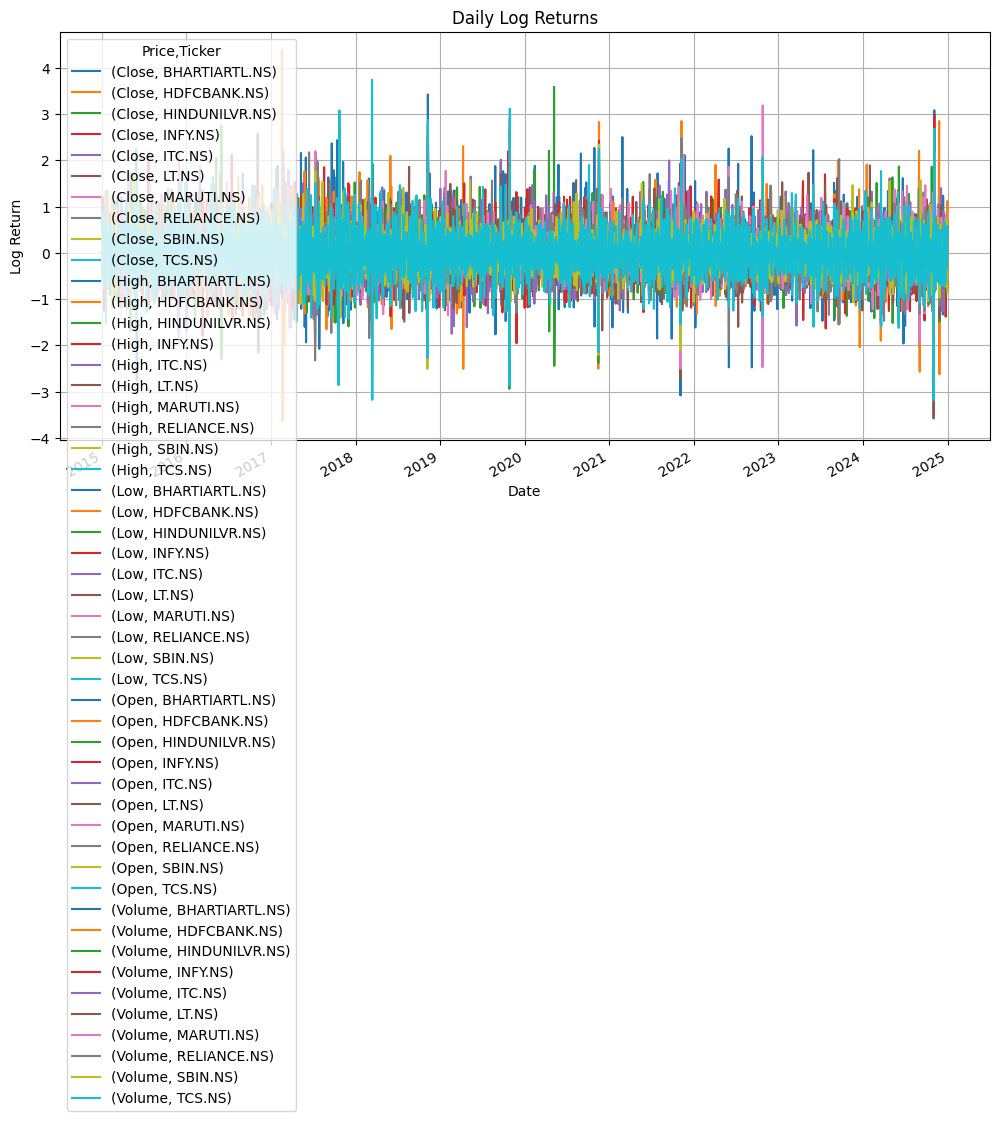

In [33]:
# Plotting adjusted close prices
data.plot(figsize=(12, 6), title='Adjusted Close Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plotting log returns to inspect volatility
log_returns.plot(figsize=(12, 6), title='Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

In [34]:
import seaborn as sns

In [36]:

# Part A.1 - Computing sample statistics for in‑sample data

# Mean vector (daily)
mean_daily = in_sample.mean()

# Covariance matrix (daily)
cov_daily = in_sample.cov()

# Correlation matrix
corr_matrix = in_sample.corr()

#  Annualizing (because these are daily log‑returns)
#  Convention: 252 trading days per year
mean_annual = mean_daily * 252
cov_annual = cov_daily * 252
std_annual = np.sqrt(np.diag(cov_annual))

print(" Mean return vector (annualized):")
display(mean_annual.to_frame("Expected Annual Return"))

print("\n Covariance matrix (annualized):")
display(cov_annual)

print("\n Correlation matrix:")
display(corr_matrix)

 Mean return vector (annualized):


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Expected Annual Return
Price  Ticker                               
Close  BHARTIARTL.NS                0.078715
       HDFCBANK.NS                  0.194482
       HINDUNILVR.NS                0.212429
       INFY.NS                      0.187526
       ITC.NS                      -0.001908
       LT.NS                        0.062166
       MARUTI.NS                    0.150445
       RELIANCE.NS                  0.265050
       SBIN.NS                     -0.016733
       TCS.NS                       0.158830
High   BHARTIARTL.NS                0.080679
       HDFCBANK.NS                  0.194973
       HINDUNILVR.NS                0.213185
       INFY.NS                      0.187224
       ITC.NS                      -0.000853
       LT.NS                        0.063875
       MARUTI.NS                    0.150519
       RELIANCE.NS                  0.266533
       SBIN.NS                     -0.015855
       TCS.NS                       0.159897
Low    BHARTIARTL.NS                0.082940
       HDFCBANK.NS                  0.194400
       HINDUNILVR.NS                0.212799
       INFY.NS                      0.186748
       ITC.NS                      -0.001740
       LT.NS                        0.062669
       MARUTI.NS                    0.149936
       RELIANCE.NS                  0.265291
       SBIN.NS                     -0.016395
       TCS.NS                       0.158075
Open   BHARTIARTL.NS                0.085209
       HDFCBANK.NS                  0.194516
       HINDUNILVR.NS                0.212280
       INFY.NS                      0.186251
       ITC.NS                      -0.000858
       LT.NS                        0.063919
       MARUTI.NS                    0.150713
       RELIANCE.NS                  0.266060
       SBIN.NS                     -0.015859
       TCS.NS                       0.159603
Volume BHARTIARTL.NS                0.317056
       HDFCBANK.NS                  0.312167
       HINDUNILVR.NS                0.259821
       INFY.NS                      0.223386
       ITC.NS                       0.336025
       LT.NS                        0.298594
       MARUTI.NS                         NaN
       RELIANCE.NS                  0.314606
       SBIN.NS                      0.267288
       TCS.NS                       0.408812


 Covariance matrix (annualized):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Price                        Close                                      \
Ticker               BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS   INFY.NS   
Price  Ticker                                                            
Close  BHARTIARTL.NS      0.113196    0.021922      0.017125  0.016923   
       HDFCBANK.NS        0.021922    0.052542      0.016526  0.017795   
       HINDUNILVR.NS      0.017125    0.016526      0.056264  0.015137   
       INFY.NS            0.016923    0.017795      0.015137  0.080013   
       ITC.NS             0.020843    0.020418      0.015045  0.012434   
       LT.NS              0.028052    0.034050      0.020381  0.018396   
       MARUTI.NS          0.027099    0.032325      0.024272  0.018962   
       RELIANCE.NS        0.027557    0.028893      0.021174  0.021214   
       SBIN.NS            0.034950    0.036824      0.020060  0.021519   
       TCS.NS             0.012873    0.014594      0.013492  0.036618   
High   BHARTIARTL.NS      0.071646    0.011292      0.012999  0.009956   
       HDFCBANK.NS        0.011984    0.032154      0.010901  0.010311   
       HINDUNILVR.NS      0.008835    0.011920      0.035026  0.007215   
       INFY.NS            0.010575    0.011022      0.012152  0.053488   
       ITC.NS             0.007827    0.010740      0.009939  0.008094   
       LT.NS              0.012604    0.019519      0.011347  0.006640   
       MARUTI.NS          0.015711    0.022290      0.013708  0.009778   
       RELIANCE.NS        0.015416    0.017193      0.012810  0.010620   
       SBIN.NS            0.019410    0.022780      0.010601  0.013909   
       TCS.NS             0.005116    0.007560      0.008575  0.021031   
Low    BHARTIARTL.NS      0.060712    0.012478      0.014694  0.011014   
       HDFCBANK.NS        0.011672    0.030730      0.012183  0.011058   
       HINDUNILVR.NS      0.006076    0.008037      0.028394  0.005756   
       INFY.NS            0.012285    0.011811      0.010538  0.052735   
       ITC.NS             0.010969    0.011772      0.009907  0.010760   
       LT.NS              0.017494    0.021134      0.014843  0.011914   
       MARUTI.NS          0.014644    0.019914      0.016113  0.010270   
       RELIANCE.NS        0.017468    0.017073      0.012944  0.013986   
       SBIN.NS            0.016621    0.022628      0.012824  0.012328   
       TCS.NS             0.004748    0.006740      0.009227  0.020542   
Open   BHARTIARTL.NS      0.010688    0.004830      0.006392  0.007847   
       HDFCBANK.NS        0.005268    0.012969      0.007975  0.008178   
       HINDUNILVR.NS     -0.000585    0.003828      0.003674  0.003694   
       INFY.NS            0.005792    0.008183      0.009854  0.019234   
       ITC.NS             0.002482    0.006266      0.004174  0.010258   
       LT.NS              0.002238    0.006926      0.006479  0.003153   
       MARUTI.NS          0.006494    0.009198      0.005328  0.004225   
       RELIANCE.NS        0.008675    0.006168      0.006372  0.006851   
       SBIN.NS            0.004646    0.010660      0.008424  0.010059   
       TCS.NS             0.003056    0.005825      0.007164  0.007655   
Volume BHARTIARTL.NS      0.236336    0.002930      0.027060 -0.112568   
       HDFCBANK.NS        0.034316    0.149478      0.055011 -0.064981   
       HINDUNILVR.NS     -0.050540    0.046017      0.153933 -0.097489   
       INFY.NS           -0.043059    0.049603      0.033663  0.052665   
       ITC.NS            -0.058411    0.031068      0.114956 -0.097657   
       LT.NS             -0.048660    0.050656      0.079367 -0.118975   
       MARUTI.NS               NaN         NaN           NaN       NaN   
       RELIANCE.NS       -0.079724   -0.004161      0.014675 -0.121941   
       SBIN.NS            0.007199   -0.009739      0.001913 -0.055313   
       TCS.NS            -0.051063   -0.022681      0.019894 -0.031401   

Price                                                                     \
T


 Correlation matrix:


Price                        Close                                      \
Ticker               BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS   INFY.NS   
Price  Ticker                                                            
Close  BHARTIARTL.NS      1.000000    0.284260      0.214582  0.177825   
       HDFCBANK.NS        0.284260    1.000000      0.303951  0.274455   
       HINDUNILVR.NS      0.214582    0.303951      1.000000  0.225606   
       INFY.NS            0.177825    0.274455      0.225606  1.000000   
       ITC.NS             0.223030    0.320696      0.228357  0.158256   
       LT.NS              0.292594    0.521280      0.301529  0.228216   
       MARUTI.NS          0.266999    0.467476      0.339202  0.222216   
       RELIANCE.NS        0.270794    0.416741      0.295123  0.247954   
       SBIN.NS            0.281216    0.434895      0.228935  0.205942   
       TCS.NS             0.152622    0.253959      0.226893  0.516379   
High   BHARTIARTL.NS      0.670225    0.155042      0.172484  0.110777   
       HDFCBANK.NS        0.170545    0.671651      0.220038  0.174543   
       HINDUNILVR.NS      0.126224    0.249950      0.709776  0.122598   
       INFY.NS            0.121399    0.185715      0.197874  0.730330   
       ITC.NS             0.096562    0.194485      0.173927  0.118779   
       LT.NS              0.150225    0.341462      0.191834  0.094129   
       MARUTI.NS          0.181071    0.377064      0.224084  0.134043   
       RELIANCE.NS        0.174180    0.285131      0.205292  0.142728   
       SBIN.NS            0.169911    0.292679      0.131623  0.144811   
       TCS.NS             0.069692    0.151154      0.165683  0.340771   
Low    BHARTIARTL.NS      0.557063    0.168054      0.191233  0.120203   
       HDFCBANK.NS        0.157388    0.608198      0.233013  0.177349   
       HINDUNILVR.NS      0.088599    0.172013      0.587283  0.099833   
       INFY.NS            0.138021    0.194768      0.167930  0.704694   
       ITC.NS             0.122096    0.192337      0.156420  0.142457   
       LT.NS              0.184588    0.327311      0.222138  0.149524   
       MARUTI.NS          0.149608    0.298628      0.233493  0.124794   
       RELIANCE.NS        0.187834    0.269477      0.197423  0.178879   
       SBIN.NS            0.143717    0.287179      0.157276  0.126786   
       TCS.NS             0.061707    0.128573      0.170114  0.317573   
Open   BHARTIARTL.NS      0.091021    0.060374      0.077209  0.079489   
       HDFCBANK.NS        0.064352    0.232537      0.138187  0.118830   
       HINDUNILVR.NS     -0.007337    0.070524      0.065419  0.055156   
       INFY.NS            0.061926    0.128416      0.149440  0.244614   
       ITC.NS             0.026318    0.097501      0.062761  0.129355   
       LT.NS              0.022579    0.102573      0.092731  0.037839   
       MARUTI.NS          0.063395    0.131794      0.073774  0.049059   
       RELIANCE.NS        0.086252    0.090017      0.089859  0.081014   
       SBIN.NS            0.035885    0.120863      0.092299  0.092417   
       TCS.NS             0.037095    0.103779      0.123347  0.110519   
Volume BHARTIARTL.NS      0.071282    0.001297      0.011577 -0.040383   
       HDFCBANK.NS        0.012075    0.077201      0.027456 -0.027196   
       HINDUNILVR.NS     -0.017255    0.023060      0.074545 -0.039589   
       INFY.NS           -0.015398    0.026036      0.017075  0.022401   
       ITC.NS            -0.020435    0.015953      0.057042 -0.040635   
       LT.NS             -0.018922    0.028912      0.043775 -0.055027   
       MARUTI.NS         -0.017826    0.053093      0.033954 -0.036276   
       RELIANCE.NS       -0.031464   -0.002410      0.008215 -0.057241   
       SBIN.NS            0.003092   -0.006140      0.001165 -0.028258   
       TCS.NS            -0.017621   -0.011488      0.009737 -0.012888   

Price                                                                     \
T

In [37]:
# Computing descriptive statistics for each stock
summary_table = pd.DataFrame({
    "Average Annual Return": mean_annual,
    "Annual Std Dev": std_annual,
    "Skewness": in_sample.skew(),
    "Kurtosis": in_sample.kurt()
})

# Rounding for better readability
summary_table = summary_table.round(4)

print("Descriptive Statistics — In‑Sample Period (2015–2020):")
display(summary_table)

Descriptive Statistics — In‑Sample Period (2015–2020):


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1581: RuntimeWarning: invalid value encountered in less
  return np.where(np.abs(arg) < 1e-14, 0, arg)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Average Annual Return  Annual Std Dev  Skewness  \
Price  Ticker                                                           
Close  BHARTIARTL.NS                 0.0787          0.3364    0.3809   
       HDFCBANK.NS                   0.1945          0.2292   -0.4977   
       HINDUNILVR.NS                 0.2124          0.2372    0.8868   
       INFY.NS                       0.1875          0.2829   -0.6779   
       ITC.NS                       -0.0019          0.2778   -0.9736   
       LT.NS                         0.0622          0.2850   -0.1067   
       MARUTI.NS                     0.1504          0.3017   -0.3290   
       RELIANCE.NS                   0.2650          0.3025    0.0704   
       SBIN.NS                      -0.0167          0.3694    0.6599   
       TCS.NS                        0.1588          0.2507   -0.0882   
High   BHARTIARTL.NS                 0.0807          0.3177    1.0932   
       HDFCBANK.NS                   0.1950          0.2089    0.1561   
       HINDUNILVR.NS                 0.2132          0.2080    0.5979   
       INFY.NS                       0.1872          0.2589    0.1038   
       ITC.NS                       -0.0009          0.2409   -0.2933   
       LT.NS                         0.0639          0.2494    0.7306   
       MARUTI.NS                     0.1505          0.2579    0.3895   
       RELIANCE.NS                   0.2665          0.2631    1.1495   
       SBIN.NS                      -0.0159          0.3395    1.1706   
       TCS.NS                        0.1599          0.2182    0.4244   
Low    BHARTIARTL.NS                 0.0829          0.3239    0.3028   
       HDFCBANK.NS                   0.1944          0.2204   -0.1288   
       HINDUNILVR.NS                 0.2128          0.2038    0.0968   
       INFY.NS                       0.1867          0.2646   -1.1278   
       ITC.NS                       -0.0017          0.2670   -0.9041   
       LT.NS                         0.0627          0.2817   -0.2266   
       MARUTI.NS                     0.1499          0.2909   -0.7790   
       RELIANCE.NS                   0.2653          0.2764   -0.3369   
       SBIN.NS                      -0.0164          0.3438    0.3317   
       TCS.NS                        0.1581          0.2287   -1.0364   
Open   BHARTIARTL.NS                 0.0852          0.3490    0.3557   
       HDFCBANK.NS                   0.1945          0.2433   -0.0280   
       HINDUNILVR.NS                 0.2123          0.2368    0.2346   
       INFY.NS                       0.1863          0.2780   -0.2956   
       ITC.NS                       -0.0009          0.2804   -0.1740   
       LT.NS                         0.0639          0.2946    0.4158   
       MARUTI.NS                     0.1507          0.3045   -0.1400   
       RELIANCE.NS                   0.2661          0.2989    0.1866   
       SBIN.NS                      -0.0159          0.3848    0.3604   
       TCS.NS                        0.1596          0.2449   -0.3558   
Volume BHARTIARTL.NS                 0.3171          9.8545    0.4826   
       HDFCBANK.NS                   0.3122          8.4470    0.2645   
       HINDUNILVR.NS                 0.2598          8.7055    0.3916   
       INFY.NS                       0.2234          8.3116    0.2951   
       ITC.NS                        0.3360          8.4960    0.2097   
       LT.NS                         0.2986          7.6436    0.3569   
       MARUTI.NS                        NaN             NaN       NaN   
       RELIANCE.NS                   0.3146          7.5312    0.3372   
       SBIN.NS                       0.2673          6.9200    0.3434   
       TCS.NS                        0.4088          8.6133    0.2647   

                      Kurtosis  
Price  Ticker                   
Close  BHARTIARTL.NS    3.2987  
       HDFCBANK.NS     14.0784  
       HINDUNILVR.NS    8.1194  
       INFY.NS         12.2759  
       ITC.NS          11.7

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


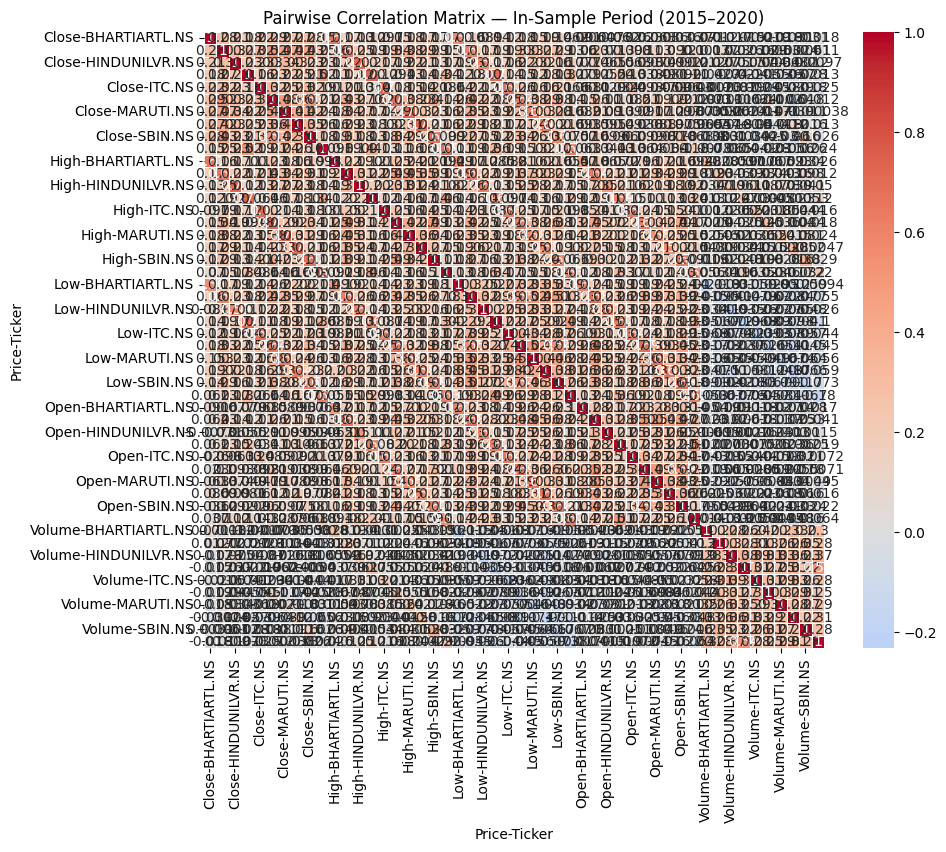

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Pairwise Correlation Matrix — In‑Sample Period (2015–2020)")
plt.show()

In [39]:
# Ensuring clean numeric data before fitting the covariance estimator

# Replacing infinite values with NaN
in_sample_clean = in_sample.replace([np.inf, -np.inf], np.nan)

# Dropping NaN rows (or you could fill them if very small number)
in_sample_clean = in_sample_clean.dropna()

# Checking that there are no issues left
print("Any NaN left?", in_sample_clean.isna().sum().sum())
print("Shape after cleaning:", in_sample_clean.shape)

Any NaN left? 0
Shape after cleaning: (1477, 50)


In [40]:
# ============================================================
# Part B: Alternative Estimator Implementation — Ledoit–Wolf Shrinkage
# ============================================================

# Objective:
# We are implementing the Ledoit–Wolf shrinkage method to estimate
# a more stable and robust covariance matrix for asset returns.
#
# Formula conceptually:
# Σ_shrink = (1 - λ) * Σ_sample + λ * F
# where:
#   - Σ_sample: sample covariance matrix
#   - F: shrinkage target (identity matrix scaled by average variance)
#   - λ: shrinkage intensity (automatically determined)
#
# Ledoit–Wolf built-in algorithm automatically computes F and λ.


# Step 1: Importing the estimator

from sklearn.covariance import LedoitWolf


# Step 2: Initializing the Ledoit–Wolf shrinkage object

lw = LedoitWolf()


# Step 3: Fitting the estimator on our cleaned in-sample log returns

# Using 'in_sample_clean' ensures that we have no NaN or infinite values.
lw.fit(in_sample_clean)


# Step 4: Extracting the estimated covariance matrix (daily)

cov_lw_daily = lw.covariance_


# Step 5: Annualizing the covariance matrix

# Convention used: 252 trading days per year. So, annual covariance = daily covariance * 252
cov_lw_annual = cov_lw_daily * 252


# Step 6: Converting the numpy array to a well-labeled DataFrame

# This helps with readability, visualization, and comparison
cov_lw_df = pd.DataFrame(
    cov_lw_annual,
    index=in_sample_clean.columns,
    columns=in_sample_clean.columns
)

# Step 7: Displaying the shrinkage covariance matrix

print("✅ Ledoit–Wolf Shrinkage Covariance Matrix (Annualized):")
display(cov_lw_df)


# Step 8:Validation and Quick Summary and also checking for any anomalies or unreasonable covariance values
print("Matrix shape:", cov_lw_df.shape)
print("Minimum covariance value:", np.min(cov_lw_df.values))
print("Maximum covariance value:", np.max(cov_lw_df.values))



✅ Ledoit–Wolf Shrinkage Covariance Matrix (Annualized):


Price                        Close                                      \
Ticker               BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS   INFY.NS   
Price  Ticker                                                            
Close  BHARTIARTL.NS      0.280945    0.021632      0.016852  0.016861   
       HDFCBANK.NS        0.021632    0.221105      0.016231  0.017694   
       HINDUNILVR.NS      0.016852    0.016231      0.224768  0.015093   
       INFY.NS            0.016861    0.017694      0.015093  0.248171   
       ITC.NS             0.020563    0.020138      0.014822  0.012344   
       LT.NS              0.027656    0.033564      0.020046  0.018295   
       MARUTI.NS          0.026762    0.031945      0.023983  0.018747   
       RELIANCE.NS        0.027108    0.028465      0.020813  0.021115   
       SBIN.NS            0.034472    0.036193      0.019619  0.021487   
       TCS.NS             0.012714    0.014533      0.013440  0.036084   
High   BHARTIARTL.NS      0.070899    0.011070      0.012781  0.009869   
       HDFCBANK.NS        0.011770    0.031770      0.010752  0.010235   
       HINDUNILVR.NS      0.008617    0.011714      0.034527  0.007253   
       INFY.NS            0.010598    0.010985      0.012130  0.052687   
       ITC.NS             0.007714    0.010591      0.009796  0.008031   
       LT.NS              0.012410    0.019218      0.011135  0.006654   
       MARUTI.NS          0.015524    0.021995      0.013515  0.009693   
       RELIANCE.NS        0.015141    0.016968      0.012618  0.010567   
       SBIN.NS            0.018885    0.022219      0.010131  0.014184   
       TCS.NS             0.005118    0.007591      0.008604  0.020635   
Low    BHARTIARTL.NS      0.059758    0.012248      0.014390  0.011093   
       HDFCBANK.NS        0.011483    0.030307      0.011969  0.011014   
       HINDUNILVR.NS      0.005864    0.007837      0.027927  0.005865   
       INFY.NS            0.011910    0.011774      0.010465  0.052142   
       ITC.NS             0.010623    0.011670      0.009781  0.010717   
       LT.NS              0.017229    0.020820      0.014592  0.011867   
       MARUTI.NS          0.014405    0.019728      0.015956  0.010139   
       RELIANCE.NS        0.017144    0.016809      0.012705  0.013945   
       SBIN.NS            0.016362    0.022164      0.012467  0.012405   
       TCS.NS             0.004657    0.006767      0.009215  0.020218   
Open   BHARTIARTL.NS      0.010555    0.004697      0.006241  0.007831   
       HDFCBANK.NS        0.005130    0.012800      0.007850  0.008138   
       HINDUNILVR.NS     -0.000759    0.003745      0.003557  0.003786   
       INFY.NS            0.005900    0.008113      0.009801  0.018884   
       ITC.NS             0.002411    0.006199      0.004122  0.010154   
       LT.NS              0.002080    0.006796      0.006329  0.003234   
       MARUTI.NS          0.006378    0.009089      0.005256  0.004197   
       RELIANCE.NS        0.008456    0.006080      0.006257  0.006849   
       SBIN.NS            0.004267    0.010304      0.008034  0.010336   
       TCS.NS             0.003170    0.005767      0.007121  0.007471   
Volume BHARTIARTL.NS      0.237475    0.003272      0.027924 -0.113755   
       HDFCBANK.NS        0.033180    0.151335      0.057726 -0.067242   
       HINDUNILVR.NS     -0.051854    0.045762      0.152001 -0.095562   
       INFY.NS           -0.041976    0.050204      0.034537  0.050605   
       ITC.NS            -0.058583    0.034429      0.117041 -0.099564   
       LT.NS             -0.045097    0.051251      0.080210 -0.120343   
       MARUTI.NS         -0.043373    0.088004      0.058235 -0.074187   
       RELIANCE.NS       -0.078705   -0.003706      0.014912 -0.120930   
       SBIN.NS            0.003331   -0.010125      0.000617 -0.052107   
       TCS.NS            -0.053881   -0.019738      0.021546 -0.031686   

Price                                                                     \
T

Matrix shape: (50, 50)
Minimum covariance value: -0.6420289921091904
Maximum covariance value: 96.05556432250617


In [41]:
# Computing difference between covariance matrices
diff_cov = cov_annual - cov_lw_df

print(" Difference between Sample and Ledoit‑Wolf Covariance (annualized):")
display(diff_cov.round(6))

# Comparing average variance and correlation magnitude
avg_var_sample = np.mean(np.diag(cov_annual))
avg_var_lw = np.mean(np.diag(cov_lw_df))

print(f"\nAverage variance (Sample): {avg_var_sample:.6f}")
print(f"Average variance (Ledoit-Wolf): {avg_var_lw:.6f}")

 Difference between Sample and Ledoit‑Wolf Covariance (annualized):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Price                        Close                                      \
Ticker               BHARTIARTL.NS HDFCBANK.NS HINDUNILVR.NS   INFY.NS   
Price  Ticker                                                            
Close  BHARTIARTL.NS     -0.167749    0.000290      0.000273  0.000063   
       HDFCBANK.NS        0.000290   -0.168563      0.000295  0.000101   
       HINDUNILVR.NS      0.000273    0.000295     -0.168504  0.000045   
       INFY.NS            0.000063    0.000101      0.000045 -0.168157   
       ITC.NS             0.000280    0.000281      0.000223  0.000090   
       LT.NS              0.000397    0.000486      0.000336  0.000101   
       MARUTI.NS          0.000337    0.000380      0.000289  0.000215   
       RELIANCE.NS        0.000449    0.000428      0.000361  0.000099   
       SBIN.NS            0.000478    0.000631      0.000441  0.000031   
       TCS.NS             0.000159    0.000061      0.000052  0.000534   
High   BHARTIARTL.NS      0.000747    0.000221      0.000219  0.000087   
       HDFCBANK.NS        0.000214    0.000385      0.000149  0.000077   
       HINDUNILVR.NS      0.000218    0.000205      0.000500 -0.000039   
       INFY.NS           -0.000023    0.000037      0.000022  0.000800   
       ITC.NS             0.000113    0.000149      0.000143  0.000063   
       LT.NS              0.000194    0.000301      0.000212 -0.000014   
       MARUTI.NS          0.000186    0.000294      0.000192  0.000085   
       RELIANCE.NS        0.000275    0.000224      0.000191  0.000054   
       SBIN.NS            0.000525    0.000560      0.000470 -0.000275   
       TCS.NS            -0.000002   -0.000032     -0.000029  0.000397   
Low    BHARTIARTL.NS      0.000954    0.000230      0.000303 -0.000079   
       HDFCBANK.NS        0.000189    0.000424      0.000214  0.000044   
       HINDUNILVR.NS      0.000212    0.000200      0.000466 -0.000109   
       INFY.NS            0.000375    0.000037      0.000073  0.000592   
       ITC.NS             0.000346    0.000102      0.000126  0.000043   
       LT.NS              0.000265    0.000314      0.000250  0.000047   
       MARUTI.NS          0.000239    0.000186      0.000156  0.000131   
       RELIANCE.NS        0.000323    0.000265      0.000238  0.000041   
       SBIN.NS            0.000260    0.000465      0.000357 -0.000077   
       TCS.NS             0.000090   -0.000027      0.000012  0.000324   
Open   BHARTIARTL.NS      0.000133    0.000133      0.000151  0.000017   
       HDFCBANK.NS        0.000138    0.000169      0.000125  0.000040   
       HINDUNILVR.NS      0.000174    0.000083      0.000118 -0.000092   
       INFY.NS           -0.000109    0.000069      0.000053  0.000350   
       ITC.NS             0.000072    0.000067      0.000051  0.000104   
       LT.NS              0.000158    0.000130      0.000151 -0.000081   
       MARUTI.NS          0.000116    0.000109      0.000072  0.000028   
       RELIANCE.NS        0.000219    0.000089      0.000115  0.000001   
       SBIN.NS            0.000378    0.000356      0.000390 -0.000277   
       TCS.NS            -0.000114    0.000058      0.000043  0.000183   
Volume BHARTIARTL.NS     -0.001139   -0.000343     -0.000864  0.001188   
       HDFCBANK.NS        0.001136   -0.001857     -0.002714  0.002262   
       HINDUNILVR.NS      0.001314    0.000254      0.001933 -0.001926   
       INFY.NS           -0.001083   -0.000600     -0.000874  0.002061   
       ITC.NS             0.000171   -0.003361     -0.002085  0.001908   
       LT.NS             -0.003562   -0.000595     -0.000843  0.001369   
       MARUTI.NS               NaN         NaN           NaN       NaN   
       RELIANCE.NS       -0.001019   -0.000454     -0.000237 -0.001011   
       SBIN.NS            0.003868    0.000386      0.001296 -0.003206   
       TCS.NS             0.002818   -0.002943     -0.001652  0.000285   

Price                                                                     \
T


Average variance (Sample): nan
Average variance (Ledoit-Wolf): 13.584252


In [43]:

# Ensurimg both sample and Ledoit–Wolf covariance are clean


# Step 1: Reconfirming that 'in_sample_clean' has no missing or infinite values
print("Checking data quality before covariance computations:")
print("Any NaN or Inf left in data? ->", 
      in_sample_clean.replace([np.inf, -np.inf], np.nan).isna().sum().sum())

# Step 2: Computing clean sample-based covariance (daily)
cov_daily_clean = in_sample_clean.cov()

# Step 3: Annualizing sample covariance (same convention)
# Convention reminder:
#   - Mean annual = daily mean × 252
#   - Covariance annual = daily covariance × 252
cov_annual_clean = cov_daily_clean * 252

# Step 4: Computing average variance (diagonals)
avg_var_sample = np.mean(np.diag(cov_annual_clean))
avg_var_lw = np.mean(np.diag(cov_lw_df))

# Step 5: Printing to compare
print("\n✅ Comparison of Average Variance (Annualized):")
print(f"Average variance (Sample, clean): {avg_var_sample:.6f}")
print(f"Average variance (Ledoit-Wolf):  {avg_var_lw:.6f}")

# Step 6: Sanity check difference
if np.isnan(avg_var_sample):
    print(" Warning: Sample covariance still contains NaNs — check cleaning steps.")
else:
    print(" Both covariance matrices are now clean and comparable.")

Checking data quality before covariance computations:
Any NaN or Inf left in data? -> 0

✅ Comparison of Average Variance (Annualized):
Average variance (Sample, clean): 13.593456
Average variance (Ledoit-Wolf):  13.584252
 Both covariance matrices are now clean and comparable.


In [48]:
# FIXING MultiIndex problem 

if isinstance(cov_annual_clean.columns, pd.MultiIndex):
    cov_annual_clean.columns = cov_annual_clean.columns.get_level_values(-1)
    cov_annual_clean.index = cov_annual_clean.index.get_level_values(-1)
    print("✅ Flattened MultiIndex in covariance matrix.")
else:
    print("✅ Covariance matrix already has flat column/index names.")



✅ Flattened MultiIndex in covariance matrix.


In [49]:

# Part C — Diversification and Portfolio Variance

# Goal:
#   - For k = 1 ... 10 stocks, compute portfolio variance of
#     all equal‑weighted combinations.
#   - Recording mean, 10th, 50th, 90th percentiles for each k.
#   - Visualizing diversification effect.

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Confirming we have the cleaned covariance matrix from Part B
print(" Checking covariance matrix you will use:")
print(f"Matrix dimensions: {cov_annual_clean.shape}")
print(f"Ticker count: {len(cov_annual_clean.columns)}")
print("Ticker list:", list(cov_annual_clean.columns))
print("----------------------------------------------------\n")

# Confirming annualization convention
print(" Annualization convention: 252 trading days/year")
print("All portfolio variances computed in ANNUALIZED terms.\n")

 Checking covariance matrix you will use:
Matrix dimensions: (50, 50)
Ticker count: 50
Ticker list: ['BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'LT.NS', 'MARUTI.NS', 'RELIANCE.NS', 'SBIN.NS', 'TCS.NS', 'BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'LT.NS', 'MARUTI.NS', 'RELIANCE.NS', 'SBIN.NS', 'TCS.NS', 'BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'LT.NS', 'MARUTI.NS', 'RELIANCE.NS', 'SBIN.NS', 'TCS.NS', 'BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'LT.NS', 'MARUTI.NS', 'RELIANCE.NS', 'SBIN.NS', 'TCS.NS', 'BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'LT.NS', 'MARUTI.NS', 'RELIANCE.NS', 'SBIN.NS', 'TCS.NS']
----------------------------------------------------

 Annualization convention: 252 trading days/year
All portfolio variances computed in ANNUALIZED terms.



In [60]:

# Portfolio_variance() with proper shape handling


def portfolio_variance(cov_matrix, subset_tickers):
    """
    Computes variance of an equally weighted portfolio for a given subset of tickers.
    Handles both single- and multi-asset subsets safely.
    -------------------------------------------------------------
    Parameters:
        cov_matrix: Pandas DataFrame (annualized covariance matrix)
        subset_tickers: list/tuple of selected stock tickers
    Returns:
        variance (float)
    -------------------------------------------------------------
    """
    # Ensuring subset_tickers is always a list even when a single asset is passed
    if isinstance(subset_tickers, str):
        subset_tickers = [subset_tickers]
    if isinstance(subset_tickers, tuple):
        subset_tickers = list(subset_tickers)

    k = len(subset_tickers)

    # Extracting the covariance submatrix as a numpy array
    sub_cov = cov_matrix.loc[subset_tickers, subset_tickers].to_numpy()

    # Constructing equal weights: 1/k each
    w = np.repeat(1 / k, k).reshape(k, 1)

    # Computing portfolio variance = w'Σw
    var_p = float(np.dot(w.T, np.dot(sub_cov, w)))

    # Debugging prints for small subsets (so we can see progress)
    if k <= 2:
        print(f"Subset: {subset_tickers}, Variance: {var_p:.6f}")
    
    return var_p

In [61]:

# Collapsing duplicate ticker labels in covariance matrix

print("Original shape:", cov_annual_clean.shape)

# 1️Grouping by ticker name on both rows and columns and take the mean
cov_fixed = (
    cov_annual_clean.groupby(level=0, axis=0).mean()
                    .groupby(level=0, axis=1).mean()
)

# Replacing the old matrix with the new clean one
cov_annual_clean = cov_fixed.copy()

# Verifying new shape and contents
print(" Cleaned covariance matrix to unique tickers only.")
print("New shape:", cov_annual_clean.shape)
print("Ticker list:", list(cov_annual_clean.columns))

Original shape: (10, 10)
 Cleaned covariance matrix to unique tickers only.
New shape: (10, 10)
Ticker list: ['BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'LT.NS', 'MARUTI.NS', 'RELIANCE.NS', 'SBIN.NS', 'TCS.NS']


/tmp/ipykernel_37/433486896.py:7: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  cov_annual_clean.groupby(level=0, axis=0).mean()
/tmp/ipykernel_37/433486896.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(level=0, axis=1).mean()


In [62]:
tickers_list = list(cov_annual_clean.columns)
results = []

print(" Starting diversification computation...\n")

for k in range(1, len(tickers_list) + 1):
    subset_vars = []
    combs = list(itertools.combinations(tickers_list, k))
    print(f"Computing {len(combs)} combinations for k = {k} ...")
    
    for subset in combs:
        var_p = portfolio_variance(cov_annual_clean, subset)
        subset_vars.append(var_p)
    
    mean_var = np.mean(subset_vars)
    p10 = np.percentile(subset_vars, 10)
    p50 = np.percentile(subset_vars, 50)
    p90 = np.percentile(subset_vars, 90)
    
    print(f"Summary for k={k}:")
    print(f"  Mean : {mean_var:.6f}")
    print(f"  10th : {p10:.6f}")
    print(f"  50th : {p50:.6f}")
    print(f"  90th : {p90:.6f}\n")
    
    results.append({"k": k, "mean_variance": mean_var, "p10": p10, "p50": p50, "p90": p90})

diversification_df = pd.DataFrame(results)
print("Finished computing all portfolio variances.\n")
display(diversification_df)

🚀 Starting diversification computation...

Computing 10 combinations for k = 1 ...
Subset: ['BHARTIARTL.NS'], Variance: 3.952891
Subset: ['HDFCBANK.NS'], Variance: 2.908956
Subset: ['HINDUNILVR.NS'], Variance: 3.052212
Subset: ['INFY.NS'], Variance: 2.814523
Subset: ['ITC.NS'], Variance: 2.901018
Subset: ['LT.NS'], Variance: 2.390450
Subset: ['MARUTI.NS'], Variance: 2.190406
Subset: ['RELIANCE.NS'], Variance: 2.332562
Subset: ['SBIN.NS'], Variance: 2.035165
Subset: ['TCS.NS'], Variance: 2.984555
Summary for k=1:
  Mean : 2.756274
  10th : 2.174881
  50th : 2.857771
  90th : 3.142280

Computing 45 combinations for k = 2 ...
Subset: ['BHARTIARTL.NS', 'HDFCBANK.NS'], Variance: 2.046578
Subset: ['BHARTIARTL.NS', 'HINDUNILVR.NS'], Variance: 2.231585
Subset: ['BHARTIARTL.NS', 'INFY.NS'], Variance: 2.110661
Subset: ['BHARTIARTL.NS', 'ITC.NS'], Variance: 2.113957
Subset: ['BHARTIARTL.NS', 'LT.NS'], Variance: 1.894591
Subset: ['BHARTIARTL.NS', 'MARUTI.NS'], Variance: 1.827386
Subset: ['BHARTIAR

/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array wit

Summary for k=4:
  Mean : 1.273814
  10th : 1.129659
  50th : 1.266677
  90th : 1.427112

Computing 252 combinations for k = 5 ...
Summary for k=5:
  Mean : 1.174983
  10th : 1.066425
  50th : 1.167107
  90th : 1.287652

Computing 210 combinations for k = 6 ...


/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array wit

Summary for k=6:
  Mean : 1.109096
  10th : 1.025026
  50th : 1.103535
  90th : 1.203767

Computing 120 combinations for k = 7 ...
Summary for k=7:
  Mean : 1.062034
  10th : 0.992483
  50th : 1.058066
  90th : 1.132729

Computing 45 combinations for k = 8 ...
Summary for k=8:
  Mean : 1.026737
  10th : 0.975241
  50th : 1.026260
  90th : 1.085268

Computing 10 combinations for k = 9 ...
Summary for k=9:
  Mean : 0.999284
  10th : 0.967326
  50th : 0.992492
  90th : 1.033043

Computing 1 combinations for k = 10 ...
Summary for k=10:
  Mean : 0.977322
  10th : 0.977322
  50th : 0.977322
  90th : 0.977322

✅ Finished computing all portfolio variances.



/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_p = float(np.dot(w.T, np.dot(sub_cov, w)))
/tmp/ipykernel_37/3426244943.py:31: DeprecationWarning: Conversion of an array wit

,k,mean_variance,p10,p50,p90
0,1,2.756274,2.174881,2.857771,3.142280
1,2,1.767967,1.473113,1.727622,2.093328
2,3,1.438532,1.247998,1.423056,1.654150
3,4,1.273814,1.129659,1.266677,1.427112
4,5,1.174983,1.066425,1.167107,1.287652
5,6,1.109096,1.025026,1.103535,1.203767
6,7,1.062034,0.992483,1.058066,1.132729
7,8,1.026737,0.975241,1.026260,1.085268
8,9,0.999284,0.967326,0.992492,1.033043
9,10,0.977322,0.977322,0.977322,0.977322


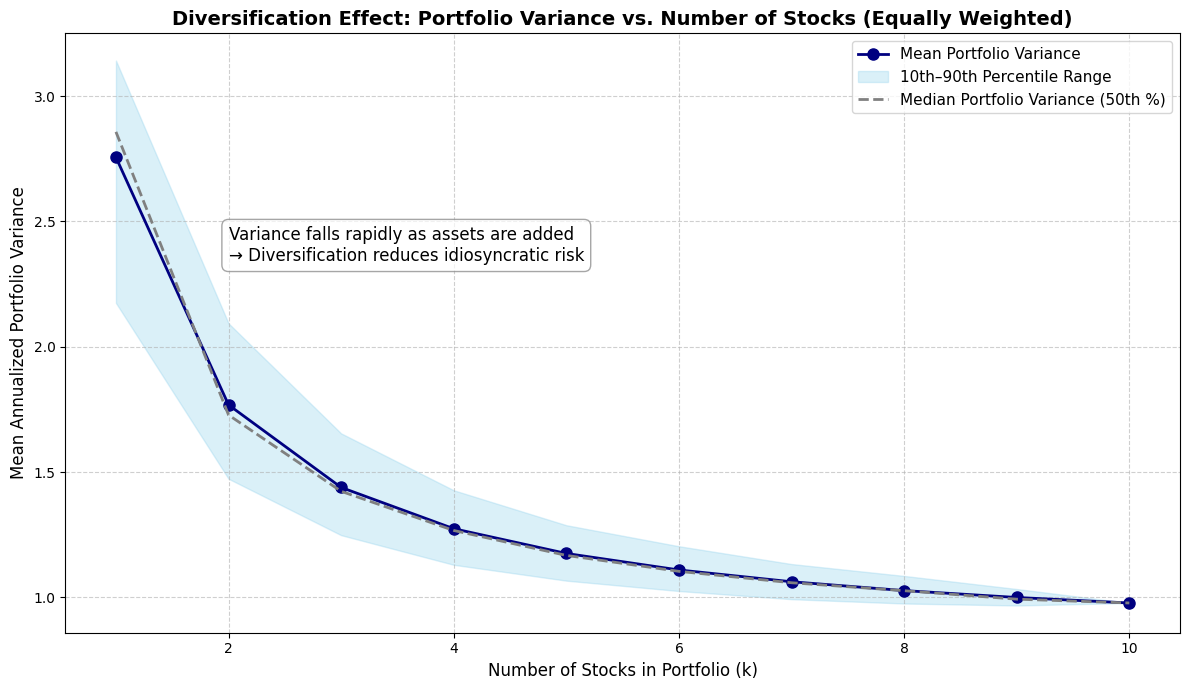


📊 Interpretation:
• The blue line shows the mean (average) portfolio variance for equally weighted portfolios of size k.
• The shaded blue band shows the spread between the 10th and 90th percentiles across all possible combinations.
• As k increases, the mean variance declines sharply at first and then flattens.
• The narrowing shaded band confirms that larger portfolios have more stable risk.

✅ This plot visually confirms the diversification effect —
   adding more assets lowers the portfolio’s total risk but with diminishing marginal benefit.


In [64]:

# Visualization: Diversification Effect — Portfolio Variance vs. Number of Stocks
plt.figure(figsize=(12, 7))

# Plotting mean portfolio variance (solid line with markers)
plt.plot(
    diversification_df["k"],
    diversification_df["mean_variance"],
    color="navy",
    marker="o",
    linewidth=2.0,
    markersize=8,
    label="Mean Portfolio Variance"
)


#  Shaded area for dispersion (10th–90th percentile)

plt.fill_between(
    diversification_df["k"],
    diversification_df["p10"],
    diversification_df["p90"],
    color="skyblue",
    alpha=0.3,
    label="10th–90th Percentile Range"
)


# Median variance line for additional clarity!

plt.plot(
    diversification_df["k"],
    diversification_df["p50"],
    linestyle="--",
    color="gray",
    linewidth=2,
    label="Median Portfolio Variance (50th %)"
)


plt.text(
    2, diversification_df["mean_variance"].max() * 0.85,
    "Variance falls rapidly as assets are added\n"
    "→ Diversification reduces idiosyncratic risk",
    fontsize=12,
    color="black",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray", alpha=0.7)
)


# Labels, title, and formatting

plt.title(
    "Diversification Effect: Portfolio Variance vs. Number of Stocks (Equally Weighted)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Number of Stocks in Portfolio (k)", fontsize=12)
plt.ylabel("Mean Annualized Portfolio Variance", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=11, loc="upper right")
plt.tight_layout()


# Showing the chart

plt.show()


#  Printing interpretation 

print("\n📊 Interpretation:")
print("• The blue line shows the mean (average) portfolio variance for equally weighted portfolios of size k.")
print("• The shaded blue band shows the spread between the 10th and 90th percentiles across all possible combinations.")
print("• As k increases, the mean variance declines sharply at first and then flattens.")
print("• The narrowing shaded band confirms that larger portfolios have more stable risk.")
print("\n✅ This plot visually confirms the diversification effect —")
print("   adding more assets lowers the portfolio’s total risk but with diminishing marginal benefit.")